<a href="https://colab.research.google.com/github/PaprikaSteiger/CNN_GAN_tensorflow_vs_pytorch/blob/master/cnngan_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a CNNGAN with tensorflow

## 1. Import and Preprocessing
### a) Importing modules

In [ ]:
# Load required packages - data handling & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Load required packages - deep learning 
import tensorflow as tf
from tensorflow import keras

In [ ]:
print(f"tensorflow: {tf.__version__}")
import sys
print(f"python: {sys.version[:5]}")

tensorflow: 2.4.1
python: 3.7.1


### b) Importing the data

In [ ]:
#download and save to file
#urllib.request.urlretrieve(
#    "https://media.githubusercontent.com/media/mmeierer/CNN---TensorFlow-vs-PyTorch/main/fashion-mnist_train.csv",
#    "fashion-mnist_train.csv")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
del y_train
del x_test
del y_test

In [ ]:
#train_data = pd.read_csv('https://media.githubusercontent.com/media/PaprikaSteiger/CNN_GAN_tensorflow_vs_pytorch/master/fashion-mnist_train.csv')

In [ ]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_images = train_data.iloc[:,1:]

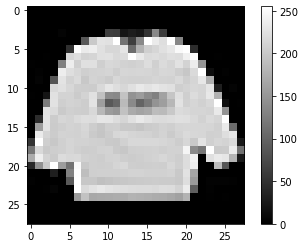

In [ ]:
plt.figure()
plt.imshow(train_images.values[0].reshape(28,28), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c) Data preparation

In [ ]:
# use maximum normalization
train_images = train_images / np.float32(255)

In [ ]:
train_images.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,0.000000,0.411765,0.360784,0.396078,0.419608,0.392157,0.517647,0.000000,0.000000,0.007843,0.015686,0.0,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.588235,0.890196,...,0.827451,0.862745,0.839216,0.290196,0.000000,1.000000,0.870588,0.501961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172549,0.047059,0.0,0.0,0.156863,0.525490,0.635294,0.749020,0.839216,0.639216,0.572549,0.647059,0.309804,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,0.447059,0.717647,0.439216,0.215686,0.090196,0.282353,0.400000,0.647059,0.627451,0.109804,0.000000,0.0,0.000000,0.003922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.094118,0.737255,0.639216,0.364706,0.533333,...,0.670588,0.976471,0.811765,0.772549,0.792157,0.176471,0.000000,0.011765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.003922,0.0,0.0,0.000000,0.086275,0.082353,0.098039,0.270588,0.203922,0.176471,0.290196,0.152941,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.180392,0.000000,0.082353,0.266667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.098039,0.733333,0.741176,0.000000,...,0.901961,0.929412,0.898039,0.000000,0.000000,0.003922,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.266667,0.454902,0.439216,0.533333,0.576471,0.564706,0.474510,0.400000,0.247059,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0



## 2. Model specific data preparation (tensorflow)
## a) Load the data

In [ ]:
x_train_tf = tf.convert_to_tensor(train_images.values.reshape((-1, 28, 28, 1)))

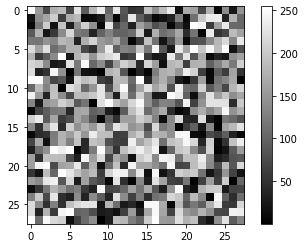

In [ ]:
# use random seed to create fake input data
seed = tf.random.uniform([28,28], 0, 1, tf.float32)
seed_im = seed.numpy() * 255
plt.figure()
plt.imshow(seed_im, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### b) Tensor view of the data

In [ ]:
x_train_tf.shape

TensorShape([60000, 28, 28, 1])

In [ ]:
seed.shape

TensorShape([28, 28])

In [ ]:
x_train_tf[0][5]

<tf.Tensor: shape=(28, 1), dtype=float32, numpy=
array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.18431373],
       [0.9882353 ],
       [0.91764706],
       [0.93333334],
       [0.8784314 ],
       [0.84313726],
       [0.84313726],
       [0.8980392 ],
       [0.42352942],
       [0.7058824 ],
       [0.8117647 ],
       [0.8392157 ],
       [0.8784314 ],
       [0.90588236],
       [0.9764706 ],
       [0.99607843],
       [0.1764706 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)>

## 3. Model definition

### a.1) Generator

In [ ]:
# for weight initialization
initializer_nn = tf.random_uniform_initializer(minval=-1, maxval=1, seed=123)
def generator_model():   
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2DTranspose(64, (7,7), input_shape=(1, 1, 100), strides=1, padding='valid', use_bias=True, name="Conv2D1"))
    model.add(keras.layers.BatchNormalization(name="Batchnorm1"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu1"))
    assert model.output_shape == (None, 7, 7, 64)

    model.add(keras.layers.Conv2DTranspose(32, (8, 8), strides=(1, 1), padding='valid', use_bias=True, name="Conv2D2"))
    assert model.output_shape == (None, 14, 14, 32)
    model.add(keras.layers.BatchNormalization(name="Batchnorm2"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu2"))

    model.add(keras.layers.Conv2DTranspose(1, (15, 15), strides=(1, 1), padding='valid', use_bias=True, name="Conv2D3"))
    model.add(keras.layers.Activation(keras.activations.sigmoid, name="Sigmoid1"))
    assert model.output_shape == (None, 28, 28, 1)

    return model
generator = generator_model()

In [ ]:
# generated image not trained
fake_im_not_trained = generator(tf.random.normal([1, 1, 1, 100], 0, 1, tf.float32))
fake_im_not_trained.shape

TensorShape([1, 28, 28, 1])

###  a.2) Inspect the generator model

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D1 (Conv2DTranspose)    (None, 7, 7, 64)          313664    
_________________________________________________________________
Batchnorm1 (BatchNormalizati (None, 7, 7, 64)          256       
_________________________________________________________________
LeakyRelu1 (LeakyReLU)       (None, 7, 7, 64)          0         
_________________________________________________________________
Conv2D2 (Conv2DTranspose)    (None, 14, 14, 32)        131104    
_________________________________________________________________
Batchnorm2 (BatchNormalizati (None, 14, 14, 32)        128       
_________________________________________________________________
LeakyRelu2 (LeakyReLU)       (None, 14, 14, 32)        0         
_________________________________________________________________
Conv2D3 (Conv2DTranspose)    (None, 28, 28, 1)         7

### a.3) Inspect the first convolutional layer

In [ ]:
hidden1_tf_ante = generator.layers[0]
weights_tf_ante, biases_tf_ante = hidden1_tf_ante.get_weights()
weights_tf_ante[0]

array([[[ 1.17349569e-02,  1.97003502e-02,  3.37529555e-03, ...,
         -1.83218680e-02,  1.75963696e-02, -2.57165506e-02],
        [ 1.88944321e-02,  2.58057192e-03, -5.91061078e-03, ...,
         -3.38664465e-03,  1.09844487e-02, -1.01208780e-02],
        [ 2.44344193e-02, -9.35407542e-03,  1.55514833e-02, ...,
          2.46017445e-02, -7.24623911e-03, -1.23612834e-02],
        ...,
        [ 1.32317077e-02,  2.12547686e-02,  1.80099253e-02, ...,
          1.96534023e-03,  1.38101708e-02,  1.76015105e-02],
        [ 1.05215982e-03, -2.31731683e-05,  4.23604809e-03, ...,
          6.09599240e-03,  1.45365428e-02, -4.79436480e-03],
        [-3.79423797e-03,  1.30658839e-02, -1.03510041e-02, ...,
          1.56574566e-02, -1.36418883e-02, -9.05726478e-03]],

       [[ 3.24024633e-03,  2.20413674e-02, -8.96912813e-03, ...,
          2.66891997e-02, -1.22363577e-02,  2.44430844e-02],
        [ 2.19134260e-02,  4.84880991e-03, -2.72823237e-02, ...,
          7.30694272e-03, -1.62058882e

In [ ]:
weights_tf_ante[0].shape

(7, 64, 100)

In [ ]:
biases_tf_ante

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
biases_tf_ante.shape

(64,)

### b.1) Discriminator

In [ ]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(input_shape=(28,28,1), filters=2, kernel_size=5, strides=1, padding="same", name="Conv2D1"))
    model.add(keras.layers.AveragePooling2D(pool_size=2, strides=2, name="Pooling1"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu1"))
    model.add(keras.layers.Dropout(0.3, name="Dropout1"))
    
    model.add(keras.layers.Conv2D(filters=2, kernel_size=5, strides=1, padding="same", name="Conv2D2"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu2"))
    
    model.add(keras.layers.Conv2D(filters=1, kernel_size=5, strides=1, name="conv2D3"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu3"))
    
    model.add(keras.layers.Flatten(name="Flatten1"))
    
    model.add(keras.layers.Dense(100, kernel_initializer=initializer_nn, name="Dense1"))
    model.add(keras.layers.LeakyReLU(name="LeakyRelu4"))
    
    model.add(keras.layers.Dense(64, kernel_initializer=initializer_nn, name="Dense2"))
    model.add(keras.layers.Activation(keras.activations.tanh, name="Tanh"))
    
    model.add(keras.layers.Dense(1, kernel_initializer=initializer_nn, name="Dense3"))
    model.add(keras.layers.Activation(keras.activations.sigmoid, name="Sigmoid"))
    return model
discriminator = discriminator_model()

### b.2) Inspect the discriminator model

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D1 (Conv2D)             (None, 28, 28, 2)         52        
_________________________________________________________________
Pooling1 (AveragePooling2D)  (None, 14, 14, 2)         0         
_________________________________________________________________
LeakyRelu1 (LeakyReLU)       (None, 14, 14, 2)         0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 14, 14, 2)         0         
_________________________________________________________________
Conv2D2 (Conv2D)             (None, 14, 14, 2)         102       
_________________________________________________________________
LeakyRelu2 (LeakyReLU)       (None, 14, 14, 2)         0         
_________________________________________________________________
conv2D3 (Conv2D)             (None, 10, 10, 1)        

### b.3) Inspect the first convolutional layer

In [ ]:
hidden2_tf_ante = discriminator.layers[0]
weights2_tf_ante, biases2_tf_ante = hidden2_tf_ante.get_weights()
weights2_tf_ante[0]

array([[[ 0.08929583,  0.05092797]],

       [[ 0.24591658, -0.02951244]],

       [[ 0.28247198, -0.13832097]],

       [[ 0.1410583 ,  0.08244011]],

       [[ 0.09257513,  0.00590676]]], dtype=float32)

In [ ]:
biases2_tf_ante

array([0., 0.], dtype=float32)

## 4. Loss & Optimizer

### 4.a) Generator loss

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits='activation')
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 4.b) Discriminator loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## 4.c) Optimizers

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy') # only for discriminator

## 5. Training

In [ ]:
# for saving the model
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# This annotation causes the function to be "compiled".
#@tf.function
def train_step_tf(generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size = 100):
    gen_losses = []
    disc_losses = []
    for beg_i in range(0, x_train_tf.shape[0], batch_size):
        x_train_batch_tf = x_train_tf[beg_i:beg_i + batch_size]

        x_fake_batch_tf = tf.random.normal([batch_size, 1, 1, 100], 0, 1, tf.float32)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            generated_images = generator( x_fake_batch_tf, training=True)
            real_output = discriminator(x_train_batch_tf, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)
        
        train_accuracy.update_state(tf.ones_like(real_output), real_output)
        train_accuracy.update_state(tf.zeros_like(fake_output), fake_output)
    return gen_losses, disc_losses

In [ ]:
train_losses_generator_tf = []
train_losses_discriminator_tf = []
train_acc_discriminator_tf = []
epochs = 15
start = time.time()
for epoch in range(epochs):
    gen_loss, disc_loss = train_step_tf(generator, discriminator, generator_optimizer, discriminator_optimizer)
    train_loss_generator_tf = float(tf.reduce_mean(gen_loss))
    train_loss_discriminator_tf = float(tf.reduce_mean(disc_loss))
    train_losses_generator_tf.append(train_loss_generator_tf)
    train_losses_discriminator_tf.append(train_loss_discriminator_tf)

    template = ("Epoch {}, Loss_Generator: {}, Loss_Discriminator: {}, Discriminator_Accuracy: {}")
    print(template.format(epoch+1, train_loss_generator_tf, train_loss_discriminator_tf, train_accuracy.result()*100))
    train_acc_discriminator_tf.append(train_accuracy.result()*100)
    train_accuracy.reset_states()
end = time.time()
print(f"Total training time{(end - start)/60.0}")

Epoch 1, Loss_Generator: 0.9152773022651672, Loss_Discriminator: 1.4088431596755981, Discriminator_Accuracy: 65.7366714477539
Epoch 2, Loss_Generator: 0.8600758910179138, Loss_Discriminator: 1.2255518436431885, Discriminator_Accuracy: 67.36083984375
Epoch 3, Loss_Generator: 0.9105566143989563, Loss_Discriminator: 1.2490020990371704, Discriminator_Accuracy: 63.94666290283203
Epoch 4, Loss_Generator: 0.8423505425453186, Loss_Discriminator: 1.2504206895828247, Discriminator_Accuracy: 65.88333129882812
Epoch 5, Loss_Generator: 0.9626114964485168, Loss_Discriminator: 1.177001714706421, Discriminator_Accuracy: 67.54750061035156
Epoch 6, Loss_Generator: 2.1399731636047363, Loss_Discriminator: 0.7356869578361511, Discriminator_Accuracy: 84.69083404541016
Epoch 7, Loss_Generator: 2.1231014728546143, Loss_Discriminator: 0.7090948224067688, Discriminator_Accuracy: 84.6241683959961
Epoch 8, Loss_Generator: 2.2293736934661865, Loss_Discriminator: 0.6851399540901184, Discriminator_Accuracy: 85.51916

KeyboardInterrupt: ignored

### b) Training progress

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(train_acc_discriminator_tf)
plt.title('discriminator accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['discriminator_train'], loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(train_losses_generator_tf)
plt.plot(train_losses_discriminator_tf)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper right')
plt.show()

In [ ]:
print(train_losses_generator_tf)
print(train_losses_discriminator_tf)

### c1) Generator output before training

In [ ]:
fake_im_not_trained = fake_im_not_trained.numpy() * 255
fake_im_not_trained = fake_im_not_trained.reshape((28,28))
plt.figure()
plt.imshow(fake_im_not_trained, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c2) Generator output after training

In [ ]:
seed2 = tf.random.uniform([1, 1, 1, 100], 0, 1, tf.float32)
fake_im = generator(seed2, training=False)
fake_im = fake_im.numpy() * 255
fake_im = fake_im.reshape((28,28))
plt.figure()
plt.imshow(fake_im, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()